In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import datetime

# data is in PostgreSQL database
import psycopg2

# **Project Goal
The goal of this project is to evaluate the impact of Total Parenteral Nutrition (TPN) 
on survival outcomes among critically ill patients in the ICU, using real-world clinical
data from the MIMIC-IV database. The analysis aims to determine whether TPN administration 
is associated with improved survival rates, and to identify key demographic and clinical 
factors that influence ICU mortality and length of stay.

# **Project Outline

## **1-Data Extraction and Preprocessing
Extract ICU stay data and identify patients who received TPN (with or without lipids).
Select the most recent ICU stay per patient.
Merge patient demographics, race, admission info, ICD diagnosis codes, and lab events.
    
## **2-Feature Engineering
Aggregate ICD codes and lab values.
Identify the top 10 most frequent ICD diagnoses and lab items.
Binarize the ICD features and consolidate relevant patient information.
    
## **3-Survival Analysis
Conduct Kaplan-Meier survival analysis to compare TPN vs. non-TPN groups.
Perform the log-rank test to assess the statistical significance of differences.
Interpret survival curves and median ICU length of stay.

## **4-Cox Proportional Hazards Modeling
Fit a Cox model to analyze factors affecting survival, including TPN, age, gender, 
    race, and comorbidities.
Visualize model coefficients and hazard ratios.

## **5-Subgroup Analysis
Repeat the Cox model for the subgroup of patients who received TPN to identify 
        specific predictors of survival in this group.

## **6-Outcome Interpretation
Interpret findings to evaluate the association between TPN use and ICU survival.
Assess whether TPN contributes to longer ICU stays and better outcomes.
Discuss the influence of comorbidities and demographics on patient survival.

## **7-Visualization and Reporting
Generate informative plots (survival curves, boxplots, hazard plots).
Summarize findings with statistical significance and clinical relevance.



In [12]:
conn = psycopg2.connect(host='localhost', port='5432',database="mimiciv")

In [14]:
pd.read_sql('select * from mimiciv_hosp.admissions limit 10;', conn)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/654551631.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql('select * from mimiciv_hosp.admissions limit 10;', conn)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,None,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,None,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,None,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,None,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,None,EU OBSERVATION,P39NWO,EMERGENCY ROOM,None,None,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
5,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,None,EW EMER.,P42H7G,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,English,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0
6,10000084,29888819,2160-12-28 05:11:00,2160-12-28 16:07:00,None,EU OBSERVATION,P35NE4,PHYSICIAN REFERRAL,None,Medicare,English,MARRIED,WHITE,2160-12-27 18:32:00,2160-12-28 16:07:00,0
7,10000108,27250926,2163-09-27 23:17:00,2163-09-28 09:04:00,None,EU OBSERVATION,P40JML,EMERGENCY ROOM,None,None,English,SINGLE,WHITE,2163-09-27 16:18:00,2163-09-28 09:04:00,0
8,10000117,22927623,2181-11-15 02:05:00,2181-11-15 14:52:00,None,EU OBSERVATION,P47EY8,EMERGENCY ROOM,None,Medicaid,English,DIVORCED,WHITE,2181-11-14 21:51:00,2181-11-15 09:57:00,0
9,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,None,OBSERVATION ADMIT,P13ACE,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicaid,English,DIVORCED,WHITE,2183-09-18 08:41:00,2183-09-18 20:20:00,0


In [16]:
import pandas as pd

# 1. Retrieve TPN-related data (patients who received TPN)
df_tpn = pd.read_sql("""
    SELECT DISTINCT ie.subject_id, ie.stay_id
    FROM mimiciv_icu.inputevents ie
    WHERE ie.itemid IN (225916, 225917, 225918)  -- TPN with and without lipids
""", conn)

# 2. Retrieve all ICU stay data for patients
df_icustays = pd.read_sql("""
    SELECT subject_id, stay_id, hadm_id, first_careunit, last_careunit, intime, outtime, los
    FROM mimiciv_icu.icustays
""", conn)

# 3. Merge ICU stay data with TPN data to get only the patients who received TPN
df_icustays['received_tpn'] = df_icustays.apply(
    lambda row: 1 if (row['subject_id'], row['stay_id']) in df_tpn[['subject_id', 'stay_id']].values else 0, axis=1
)

# 4. Now df_icustays contains a column 'received_tpn' indicating 1 (received TPN) and 0 (did not receive TPN)
# Display the merged dataframe
df_icustays.head()


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/2771968062.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tpn = pd.read_sql("""
/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/2771968062.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_icustays = pd.read_sql("""


,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0
1,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0
2,10000980,39765666,26913865,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,0
3,10001217,37067082,24597018,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,0
4,10001217,34592300,27703517,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,0


In [17]:
#Select Most Recent ICU Stay for Each Patient
# Convert the 'intime' column to datetime format if it's not already
df_icustays['intime'] = pd.to_datetime(df_icustays['intime'], errors='coerce')

# Sort the DataFrame by subject_id and intime (in descending order to get the most recent stay first)
df_icustays_sorted = df_icustays.sort_values(by=['subject_id', 'intime'], ascending=[True, False])

# Drop duplicates, keeping only the most recent ICU stay for each patient
df_most_recent_icustay = df_icustays_sorted.drop_duplicates(subset='subject_id', keep='first')

# Display the most recent ICU stay for each patient
df_most_recent_icustay.head()


,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0
1,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0
2,10000980,39765666,26913865,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,0
4,10001217,34592300,27703517,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,0
5,10001725,31205490,25563031,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,0


In [18]:
# Extract patient information
df_patients = pd.read_sql("""
    SELECT subject_id, gender, anchor_age, anchor_year, anchor_year_group, dod
    FROM mimiciv_hosp.patients
""", conn)

# Extract race information from the admissions table
df_admissions = pd.read_sql("""
    SELECT subject_id, race
    FROM mimiciv_hosp.admissions
""", conn)

# Merge the patient and admission data on 'subject_id'
df_patient_race = pd.merge(df_patients, df_admissions, on='subject_id', how='left')

# Display the first few rows of the merged dataframe
df_patient_race.head()

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/293118458.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_patients = pd.read_sql("""
/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/293118458.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_admissions = pd.read_sql("""


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,race
0,10000032,F,52,2180,2014 - 2016,2180-09-09,WHITE
1,10000032,F,52,2180,2014 - 2016,2180-09-09,WHITE
2,10000032,F,52,2180,2014 - 2016,2180-09-09,WHITE
3,10000032,F,52,2180,2014 - 2016,2180-09-09,WHITE
4,10000048,F,23,2126,2008 - 2010,None,NaN


In [19]:
# Merge the most recent ICU stay data with the patient and race information on 'subject_id'
df_complete = pd.merge(df_most_recent_icustay, df_patient_race, on='subject_id', how='left')

# Display the first few rows of the merged dataframe
df_complete.head()

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE


In [20]:
df_complete.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'received_tpn', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'race'],
      dtype='object')

In [21]:
# Retrieve comorbidity data (ICD diagnoses)
df_comorbidities = pd.read_sql("""
    SELECT hadm_id, icd_code
    FROM mimiciv_hosp.diagnoses_icd;
""", conn)

# Display the first few rows of the retrieved data
df_comorbidities.head()


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/1368477365.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comorbidities = pd.read_sql("""


,hadm_id,icd_code
0,22595853,5723
1,22595853,78959
2,22595853,5715
3,22595853,07070
4,22595853,496


In [22]:
# Group by 'hadm_id' and aggregate all 'icd_code' for each 'hadm_id'
df_icd_aggregated = df_comorbidities.groupby('hadm_id')['icd_code'].apply(lambda x: ', '.join(x)).reset_index()
# Display the aggregated ICD codes for each 'hadm_id'
df_icd_aggregated.head()

,hadm_id,icd_code
0,20000019,"0389 , 59080 , 75310 , 5849 , 2761 , 9..."
1,20000024,"D500 , K521 , I10 , E538 , M810 , R..."
2,20000034,"K831 , K8689 , K861 , K869 , R1032 , R..."
3,20000041,"71536 , 25002 , V8541 , 4019 , 2724 , V..."
4,20000045,"A419 , N390 , C7951 , C787 , K56699 , C..."


In [23]:
# Merge the aggregated ICD codes with the df_icu_tpn DataFrame
df_complete_with_icd = pd.merge(df_complete, df_icd_aggregated, on='hadm_id', how='left')

# Display the final merged DataFrame
df_complete_with_icd.head()

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2..."


In [24]:
# Rename 'itemid' column to 'TPNid'
df_complete_with_icd.rename(columns={'itemid': 'TPNid'}, inplace=True)

# Display the updated DataFrame
df_complete_with_icd.head()


,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2..."


In [25]:
# Retrieve lab data
df_labs = pd.read_sql("""
    SELECT hadm_id, itemid, value
    FROM mimiciv_hosp.labevents; 
""", conn)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/1704226514.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_labs = pd.read_sql("""


In [26]:
# Aggregate lab data by hadm_id (concatenating itemid and values as comma-separated strings)
df_labs_aggregated = df_labs.groupby('hadm_id')['itemid'].apply(lambda x: ', '.join(x.astype(str))).reset_index()

# Merge the aggregated lab data into df_icu_tpn_with_event
df_complete_with_icd_lab = pd.merge(df_complete_with_icd, df_labs_aggregated, on='hadm_id', how='left')

# Display the final merged DataFrame with event and lab data
df_complete_with_icd_lab.head()

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code,itemid
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2...","51087, 51107, 51221, 51222, 51248, 51249, 5125..."


In [27]:
# Save the dataframe df_icu_tpn_with icd to a CSV file
df_complete_with_icd.to_csv('/Users/alanoudalturki/Desktop/df_complete_with_icd.csv', index=False)

In [28]:
df_complete_with_icd

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226924,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,None,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T..."
226925,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,None,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T..."
226926,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4..."
226927,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4..."


In [29]:
#complete df
df_complete_with_icd_lab.to_csv('/Users/alanoudalturki/Desktop/df_icu.csv', index=False)

In [30]:
df_complete_with_icd_lab

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code,itemid
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2...","51087, 51107, 51221, 51222, 51248, 51249, 5125..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226924,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,None,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T...","50868, 50882, 50893, 50902, 50912, 50931, 5093..."
226925,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,None,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T...","50868, 50882, 50893, 50902, 50912, 50931, 5093..."
226926,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4...","51082, 51087, 51099, 51102, 51146, 51200, 5122..."
226927,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4...","51082, 51087, 51099, 51102, 51146, 51200, 5122..."


In [31]:
# Flatten the 'icd_code_aggregated' column into individual ICD codes for each patient
icd_codes_flat = df_complete_with_icd_lab['icd_code'].str.split(',').explode().str.strip()

# Count the frequency of each ICD code
icd_code_counts = icd_codes_flat.value_counts()

# Get the top 10 ICD codes
top_10_icd_codes = icd_code_counts.head(10)

# Display the top 10 ICD codes
print(top_10_icd_codes)

icd_code
E785      55284
Z87891    41943
I10       40157
4019      39479
N179      38693
K219      36232
I2510     34623
2724      32844
Z66       30839
D62       29216
Name: count, dtype: int64


In [32]:
# Flatten the 'lab_item_aggregated' column into individual lab items for each patient
lab_items_flat = df_complete_with_icd_lab['itemid'].str.split(',').explode().str.strip()

# Count the frequency of each lab item
lab_item_counts = lab_items_flat.value_counts()

# Get the top 10 lab items
top_10_lab_items = lab_item_counts.head(10)

# Display the top 10 lab items
print(top_10_lab_items)

itemid
50971    3305740
50983    3286108
50902    3252222
50912    3192175
51006    3184782
50882    3182036
50868    3174337
51221    3145806
50931    3144428
50960    3047942
Name: count, dtype: int64


In [33]:
# Query to get details about the top 10 lab items from the d_labitems table
top_10_lab_items_query = """
SELECT itemid, label, fluid, category
FROM mimiciv_hosp.d_labitems
WHERE itemid IN (50971, 50983, 50902, 50912, 51006, 50882, 50868, 51221, 50931, 50960);
"""


# Execute the query and fetch the data
df_lab_items_details = pd.read_sql(top_10_lab_items_query, conn)

# Query to get the long_title for the top 10 ICD codes from the d_icd_diagnoses table
top_10_icd_codes_query = """
SELECT icd_code, long_title
FROM mimiciv_hosp.d_icd_diagnoses
WHERE icd_code IN ('E785', 'Z87891', 'I10', '4019', 'N179', 'K219', 'I2510', '2724', 'Z66', 'D62');
"""

# Execute the query and fetch the data
df_icd_codes_details = pd.read_sql(top_10_icd_codes_query, conn)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/3098575443.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_lab_items_details = pd.read_sql(top_10_lab_items_query, conn)
/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1644/3098575443.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_icd_codes_details = pd.read_sql(top_10_icd_codes_query, conn)


In [34]:
# Display both results
df_lab_items_details

,itemid,label,fluid,category
0,50868,Anion Gap,Blood,Chemistry
1,50882,Bicarbonate,Blood,Chemistry
2,50902,Chloride,Blood,Chemistry
3,50912,Creatinine,Blood,Chemistry
4,50931,Glucose,Blood,Chemistry
5,50960,Magnesium,Blood,Chemistry
6,50971,Potassium,Blood,Chemistry
7,50983,Sodium,Blood,Chemistry
8,51006,Urea Nitrogen,Blood,Chemistry
9,51221,Hematocrit,Blood,Hematology


In [35]:
df_icd_codes_details

,icd_code,long_title
0,2724,Other and unspecified hyperlipidemia
1,4019,Unspecified essential hypertension
2,D62,Acute posthemorrhagic anemia
3,E785,"Hyperlipidemia, unspecified"
4,I10,Essential (primary) hypertension
5,I2510,Atherosclerotic heart disease of native corona...
6,K219,Gastro-esophageal reflux disease without esoph...
7,N179,"Acute kidney failure, unspecified"
8,Z66,Do not resuscitate
9,Z87891,Personal history of nicotine dependence


In [36]:
##df

In [4]:
df_icu_tpn = pd.read_csv('/Users/alanoudalturki/Desktop/df_icu.csv')

In [6]:
df_icu_tpn.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'received_tpn', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'race', 'icd_code',
       'itemid'],
      dtype='object')

In [8]:
df_icu_tpn

,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,anchor_age,anchor_year,anchor_year_group,dod,race,icd_code,itemid
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
1,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
2,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
3,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52,2180,2014 - 2016,2180-09-09,WHITE,"45829 , 07044 , 7994 , 2761 , 78959 , 2...","50868, 50882, 50893, 50902, 50912, 50931, 5096..."
4,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,86,2150,2008 - 2010,2152-01-30,WHITE,"5070 , 42833 , 51881 , 5849 , 5781 , 2...","51087, 51107, 51221, 51222, 51248, 51249, 5125..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226924,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,NaN,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T...","50868, 50882, 50893, 50902, 50912, 50931, 5093..."
226925,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,46,2147,2017 - 2019,NaN,WHITE,"T8141XA, E1110 , K632 , D682 , L02211 , T...","50868, 50882, 50893, 50902, 50912, 50931, 5093..."
226926,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4...","51082, 51087, 51099, 51102, 51146, 51200, 5122..."
226927,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,58,2164,2008 - 2010,2164-09-17,WHITE,"3453 , 51881 , 5070 , 5180 , 42741 , 4...","51082, 51087, 51099, 51102, 51146, 51200, 5122..."


In [29]:
import pandas as pd

# Example top 10 ICD codes
top_10_icd = ['2724', '4019', 'D62', 'E785', 'I10', 'I2510', 'K219', 'N179', 'Z66', 'Z87891']

# Step 1: Split the 'icd_code' column by commas into individual ICD codes
df_icu_tpn['icd_code_split'] = df_icu_tpn['icd_code'].str.split(',')

# Step 2: Flatten the list of ICD codes (expand the list into multiple rows)
df_flat = df_icu_tpn.explode('icd_code_split')

# Step 3: Remove extra spaces and strip any unwanted characters from the ICD codes
df_flat['icd_code_split'] = df_flat['icd_code_split'].str.strip()

# Step 4: Binarize the ICD codes by checking if the split ICD code exists in the top 10 list
for icd in top_10_icd:
    # Ensure that icd_code_split is treated as a string and handle NaN values
    df_flat[icd] = df_flat['icd_code_split'].apply(lambda x: 1 if str(x) == icd else 0)

# Step 5: Group by 'subject_id' to ensure each patient has a single row
df_icu_tpn_binarized = df_flat.groupby('subject_id', as_index=False).agg({
    'stay_id': 'first',  # Keep the first value of stay_id (same for all rows of a patient)
    'hadm_id': 'first',  # Same for hadm_id
    'first_careunit': 'first',
    'last_careunit': 'first',
    'intime': 'first',
    'outtime': 'first',
    'los': 'first',
    'received_tpn': 'first',
    'gender': 'first',
    'anchor_age': 'first',
    'anchor_year': 'first',
    'anchor_year_group': 'first',
    'dod': 'first',
    'race': 'first',
    **{icd: 'max' for icd in top_10_icd}  # Use max to keep 1 if any row had the ICD code, 0 if none had it
})

# Display the resulting DataFrame with each patient having one row
df_icu_tpn_binarized


,subject_id,stay_id,hadm_id,first_careunit,last_careunit,intime,outtime,los,received_tpn,gender,...,2724,4019,D62,E785,I10,I2510,K219,N179,Z66,Z87891
0,10000032,39553978,29079034,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,...,0,0,0,0,0,0,0,0,0,0
1,10000690,37081114,25860671,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,0,F,...,0,1,0,0,0,0,0,0,0,0
2,10000980,39765666,26913865,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,0,F,...,0,0,0,0,0,0,0,0,0,0
3,10001217,34592300,27703517,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,0,F,...,0,1,0,0,0,0,0,0,0,0
4,10001725,31205490,25563031,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,0,F,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65361,19999442,32336619,26785317,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,0,M,...,0,0,0,0,0,0,0,0,0,0
65362,19999625,31070865,25304202,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,0,M,...,0,0,0,0,0,0,0,0,0,0
65363,19999828,36075953,25744818,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,0,F,...,0,0,0,0,1,0,0,0,0,1
65364,19999840,38978960,21033226,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,0,M,...,1,1,0,0,0,0,0,0,0,0


In [30]:
df_icu_tpn_binarized.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'received_tpn', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'race', '2724', '4019',
       'D62', 'E785', 'I10', 'I2510', 'K219', 'N179', 'Z66', 'Z87891'],
      dtype='object')

In [31]:
import summarytools as dfSummary

# Use dfSummary function to generate the summary of the DataFrame
summary = dfSummary.dfSummary(df_icu_tpn_binarized)

# Print the summary
print(summary)


In [32]:
dfSummary.dfSummary(df_icu_tpn_binarized)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,subject_id[int64],Mean (sd) : 14998493.4 (2887822.5)min < med < max:10000032.0 < 15000454.0 < 19999987.0IQR (CV) : 5007297.8 (5.2),"65,366 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACh0lEQVR4nO3YPW8aQRRG4TuA8fCRXYEJ7mhSWkqBREOTLmV+bNp0sWSk1BRpUrmxLCFYxMaIhZDGkaiA3bHBr3Ke2rP3AmeQhdtutwa8daVzLwAco3LuBfB2OOdqZlYNeMRqu90+vdQ+uw6GGrh8ycz+FDwbej50duE3PfA9e7UPex/nXO3q6upLFEWtos+Yz+dT59zX19h/b6ghy282m4s0TT80m81fpVIpO+X50NlmZrPZbOGc+2Zmy5xHfbvd/hzHcePEc/8pekGjZrPZHQ6H8ziOc89OksTf3t52J5NJxzk3LzB/7wU99I1ajaKoNRwOn/Iuf39/3xqPx+/7/f7P6+vraZ6zoedDZz88PLwbjUafer1ep1wu53rdWZZ5M7sZDAY/Op1Org8sZK5Z2AXNssxvNpuby8vL791u93fe2WmaXmRZ9rHX65WL7H7o2/io/1HjOF7mXX46ndbMzBqNRu6zoedfYrb3vt7v95cFL0nde58V2bvo3J3ZIZe7vl6vy3nnmpmtVqtK0d2TJPF3d3etyWRSNbPiof6vQi7Jqefuzj7X3kVnP9s7n5+nIIFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIYFQIaFyzB8lSeLzPnixWHgzszRN/ePjY/2U51Vnq+4dev6Yvv4CQTdL+Ep8z6YAAAAASUVORK5CYII="">",0(0.0%)
2,stay_id[int64],Mean (sd) : 35007917.5 (2884675.8)min < med < max:30001148.0 < 35007491.0 < 39999858.0IQR (CV) : 4991416.8 (12.1),"65,366 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACfElEQVR4nO3YMY8SQRiH8XeAOxZYlxBO6LaxNLHYksZv4Ie1tZMEvgCFjRUNISGwhPUIC2KjiTE5YHdQ+JvnV997Mzv7DAm44/FowL2r3HoDwCVqt94Arss51zCzx5Lju+Px+HzN/VzLXYfqeegVM/vusfzdvrSXOOca3W73QxRFnTLz6/V66Zz7eI/PfTbUW91Qn0M/HA4PWZa9CcPwa6VSycusv1qtNs65T2a2LTHuc0l8ZqMwDHuDwWDdbrcL7TtN02A4HPYWi8WTc25dcn2fvZ9s5WSovjfU82WXPvTpdNqZTCavkyT50u/3l0UXns1mr8bj8fs4jp+q1WqhtX0uie8Fy/M8OBwOb+v1+uder/etyGyWZQ95nr+L47ha9JnN/Pd+7tP83CfqYxRFncFg8Fw0Fp+XbeZ36MvlsmFm1mq1tkVnf80HQdBMkmRbNHSfS+J7wX7ON/f7fbXo7G63q5V95t/WLrX3NE2D0WjUWSwWj2ZWKlQzM2u324VfuM/LNvM79GspE7rPJbnGBSs68yfftcvOm9nJvf/1L1O3PHT8P/gdFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRJql/xRmqZB0X+82WwCM7Msy4L5fN78l/Oqa6vu23f+kr5+AMTfUjQtOt4VAAAAAElFTkSuQmCC"">",0(0.0%)
3,hadm_id[int64],Mean (sd) : 24976595.5 (2886129.3)min < med < max:20000094.0 < 24976100.5 < 29999828.0IQR (CV) : 5003282.0 (8.7),"65,366 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQ0lEQVR4nO3Yva/SUBjH8eeUKzm82IYXYWNxdGvCwuLm6B/r6g6JM4OLEwshIaWEeokE6+R4ubQV21/y/cycnofk+xDA5XluQNMFdQ8A3OPpkQ93znXMrF3hEb/yPH/+V/NA16uhVojND4fDT1EU9UqcNTOzw+Fwcs59NbNzieOBmf0ue7dVWJKKC1rb3E12M1TnXGc0Gn0Ow3BQ9MGXy8Wb2Yf5fP5tPB4fi57fbrdvV6vVx9lsNm61WoVCvV6vb7Ise9/v938EQXAperdZpSUpvaA1z23W4CV57RO1HYbhYLFYPEdRVOiNbzabwXq97nrvL5PJ5GfRwZIk6Xjvu3Ecn6fTaVLi7ndxHH8vetas2pJUWdA6527AktyM/K7vqFEUnYvGliRJp8jrX9Lr9UrfXebs3/MVl6TUgjZg7lqWxMzseDwmzrkvL8X60B9T6qosSZ3UljtNU79cLgf7/b5tZoSKxysbupndXHD+R4UEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoWEp3telKapL/rg0+nkzcyyLPO73a77P8+r3q06d9Xz9/T1B+dJPDTP5pzMAAAAAElFTkSuQmCC"">",0(0.0%)
4,first_careunit[object],1. Medical Intensive Care Unit (M2. Cardiac Vascular Intensive Car3. Medical/Surgical Intensive Car4. Surgical Intensive Care Unit (5. Trauma SICU (TSICU)6. Coronary Care Unit (CCU)7. Neuro Intermediate8. Neuro Surgical In

# 1-Baseline Characteristics by TPN Status

In [34]:
# 1. Import libraries
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency

# 2. Prepare dataset
# Create gender_numeric if missing
if 'gender_numeric' not in df_icu_tpn_binarized.columns:
    df_icu_tpn_binarized['gender_numeric'] = df_icu_tpn_binarized['gender'].map({'M': 1, 'F': 0})

# 3. Split into TPN vs. Non-TPN groups
tpn_group = df_icu_tpn_binarized[df_icu_tpn_binarized['received_tpn'] == 1]
non_tpn_group = df_icu_tpn_binarized[df_icu_tpn_binarized['received_tpn'] == 0]

# 4. Define variables
continuous_vars = ['anchor_age', 'los']  # Age and LOS
# All the rest are categorical/binary
categorical_vars = [
    'gender_numeric', 'first_careunit', 'last_careunit', 'anchor_year', 'anchor_year_group',
    'race', '2724', '4019', 'D62', 'E785', 'I10', 'I2510', 'K219', 'N179', 'Z66', 'Z87891'
]

# 5. Initialize results list
table1_results = []

# 6. Analyze continuous variables (Mann-Whitney U test)
for var in continuous_vars:
    # Drop NaN values
    tpn_clean = tpn_group[var].dropna()
    non_tpn_clean = non_tpn_group[var].dropna()

    # Special handling:
    if var == 'anchor_age':
        # For Age, use MEAN
        tpn_value = round(tpn_clean.mean(), 2)
        non_tpn_value = round(non_tpn_clean.mean(), 2)
    else:
        # For LOS, use MEDIAN
        tpn_value = round(tpn_clean.median(), 2)
        non_tpn_value = round(non_tpn_clean.median(), 2)

    # Mann-Whitney U test
    stat, p = mannwhitneyu(tpn_clean, non_tpn_clean, alternative='two-sided')

    table1_results.append([
        var,
        tpn_value,
        non_tpn_value,
        round(p, 4)
    ])

# 7. Analyze categorical variables (Chi-square test)
for var in categorical_vars:
    if var in df_icu_tpn_binarized.columns:
        contingency_table = pd.crosstab(df_icu_tpn_binarized['received_tpn'], df_icu_tpn_binarized[var])
        if contingency_table.shape[1] == 2:  # binary
            chi2, p, _, _ = chi2_contingency(contingency_table)
            tpn_pct = round(tpn_group[var].mean() * 100, 1)
            non_tpn_pct = round(non_tpn_group[var].mean() * 100, 1)
            table1_results.append([
                var,
                f"{tpn_pct}%",
                f"{non_tpn_pct}%",
                round(p, 4)
            ])

# 8. Create DataFrame for Table 1
table1_df = pd.DataFrame(table1_results, columns=['Variable', 'TPN Group', 'Non-TPN Group', 'p-value'])

# 9. Rename variables professionally
rename_dict = {
    'anchor_age': 'Age, mean (years)',
    'los': 'ICU Length of Stay (LOS), median (days)',
    'gender_numeric': 'Male (%)',
    '2724': 'Hyperlipidemia (%)',
    '4019': 'Essential Hypertension (%)',
    'D62': 'Anemia (%)',
    'E785': 'Diabetes (%)',
    'I10': 'Hypertension (%)',
    'I2510': 'Coronary Artery Disease (%)',
    'K219': 'GERD (%)',
    'N179': 'Acute Kidney Injury (%)',
    'Z66': 'Do-Not-Resuscitate (%)',
    'Z87891': 'History of Infection (%)',
    'first_careunit': 'First ICU Care Unit',
    'last_careunit': 'Last ICU Care Unit',
    'anchor_year': 'Anchor Year',
    'anchor_year_group': 'Anchor Year Group',
    'race': 'Race'
}
table1_df['Variable'] = table1_df['Variable'].replace(rename_dict)

# 10. Display final Table 1
table1_df



,Variable,TPN Group,Non-TPN Group,p-value
0,"Age, mean (years)",61.75,63.45,0.0000
1,"ICU Length of Stay (LOS), median (days)",5.61,1.9,0.0000
2,Male (%),54.7%,56.2%,0.2551
3,Hyperlipidemia (%),11.6%,14.7%,0.0008
4,Essential Hypertension (%),19.7%,19.8%,0.9727
5,Anemia (%),16.3%,13.6%,0.0032
6,Diabetes (%),12.6%,24.0%,0.0000
7,Hypertension (%),12.4%,21.2%,0.0000
8,Coronary Artery Disease (%),8.1%,13.5%,0.0000
9,GERD (%),10.3%,12.3%,0.0207


In [35]:
#----------------------------------------------------------

# *2-Kaplan-Meier Survival Analysis

In [37]:
# Kaplan-Meier Survival Curves:
#We can use Kaplan-Meier survival curves to visualize and compare the 
#survival probabilities of ICU patients who received TPN versus those who did not.

In [38]:
"""
Difference in Survival: There appears to be a difference between the TPN and non-TPN groups,
with the TPN group having a higher survival probability at most points in the ICU stay.
This suggests that TPN may be beneficial in improving patient survival, although other 
factors should be considered before drawing any definitive conclusions.

Trend Over Time: Both groups experience a rapid drop in survival probability within 
the first 20-30 days, but the TPN group seems to have a less steep drop compared to 
the non-TPN group, indicating better outcomes or more stable patients over time.
"""

'\nDifference in Survival: There appears to be a difference between the TPN and non-TPN groups,\nwith the TPN group having a higher survival probability at most points in the ICU stay.\nThis suggests that TPN may be beneficial in improving patient survival, although other \nfactors should be considered before drawing any definitive conclusions.\n\nTrend Over Time: Both groups experience a rapid drop in survival probability within \nthe first 20-30 days, but the TPN group seems to have a less steep drop compared to \nthe non-TPN group, indicating better outcomes or more stable patients over time.\n'

In [46]:
# 1. Remove duplicates (optional, if your data has them)
df_icu_tpn_binarized_cleaned = df_icu_tpn_binarized.drop_duplicates(subset=['subject_id', 'stay_id'])

# 2. Remove rows with missing LOS (length of stay)
df_icu_tpn_binarized_cleaned = df_icu_tpn_binarized_cleaned.dropna(subset=['los'])

# 3. Create the 'event_observed' column (1 = died, 0 = survived)
df_icu_tpn_binarized_cleaned['event_observed'] = df_icu_tpn_binarized_cleaned['dod'].notna().astype(int)

# 4. OPTIONAL: Remove extreme LOS (example: stays longer than 200 days?)
df_icu_tpn_binarized_cleaned = df_icu_tpn_binarized_cleaned[df_icu_tpn_binarized_cleaned['los'] <= 200]

# 5. Reset index
df_icu_tpn_binarized_cleaned = df_icu_tpn_binarized_cleaned.reset_index(drop=True)

# Done
print(f"Shape after cleaning: {df_icu_tpn_binarized_cleaned.shape}")

Shape after cleaning: (65352, 27)


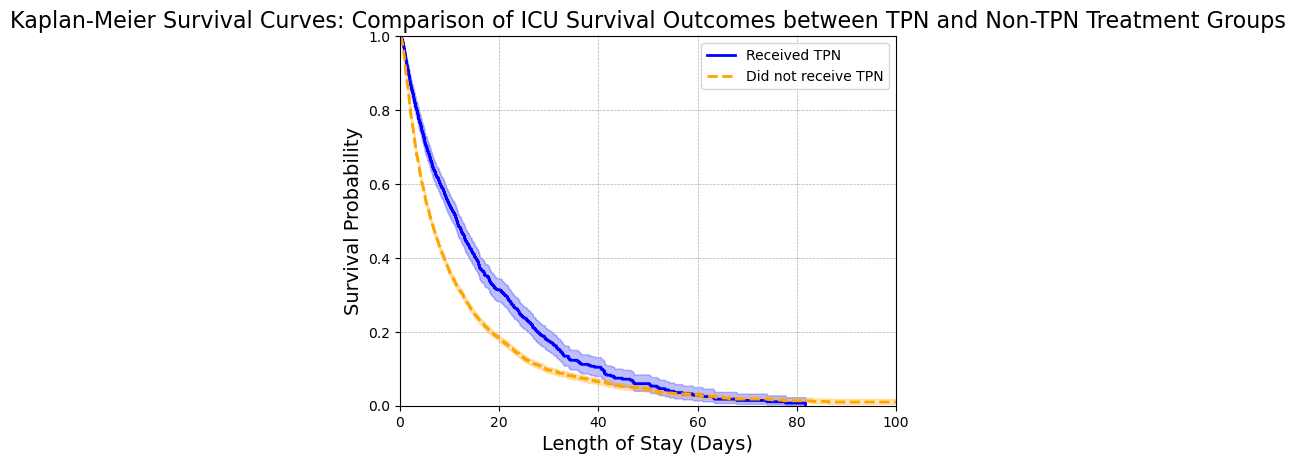

In [72]:
import matplotlib.pyplot as plt

# Step 1: Kaplan-Meier Survival Analysis
from lifelines import KaplanMeierFitter

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Separate data for TPN and Non-TPN patients
tpn_group = df_icu_tpn_binarized_cleaned[df_icu_tpn_binarized_cleaned['received_tpn'] == 1]
non_tpn_group = df_icu_tpn_binarized_cleaned[df_icu_tpn_binarized_cleaned['received_tpn'] == 0]

# Fit Kaplan-Meier for TPN group
kmf.fit(tpn_group['los'], event_observed=tpn_group['event_observed'], label="Received TPN")
kmf.plot(ci_show=True, color='blue', linestyle='-', linewidth=2)

# Fit Kaplan-Meier for Non-TPN group
kmf.fit(non_tpn_group['los'], event_observed=non_tpn_group['event_observed'], label="Did not receive TPN")
kmf.plot(ci_show=True, color='orange', linestyle='--', linewidth=2)

# Customize the plot
plt.title("Kaplan-Meier Survival Curves: Comparison of ICU Survival Outcomes between TPN and Non-TPN Treatment Groups", fontsize=16)
plt.xlabel("Length of Stay (Days)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 100)  # Limit the x-axis to better view the data
plt.ylim(0, 1)    # Limit the y-axis between 0 and 1
plt.show()



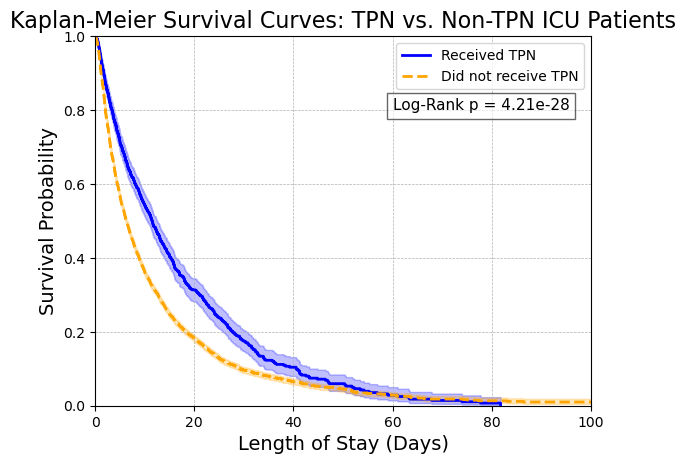

In [90]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Step 2: Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Step 3: Fit and plot TPN group
kmf.fit(tpn_group['los'], event_observed=tpn_group['event_observed'], label="Received TPN")
ax = kmf.plot(ci_show=True, color='blue', linestyle='-', linewidth=2)

# Step 4: Fit and plot Non-TPN group
kmf.fit(non_tpn_group['los'], event_observed=non_tpn_group['event_observed'], label="Did not receive TPN")
kmf.plot(ax=ax, ci_show=True, color='orange', linestyle='--', linewidth=2)

# Step 5: Perform log-rank test
results = logrank_test(tpn_group['los'], non_tpn_group['los'], 
                       event_observed_A=tpn_group['event_observed'], 
                       event_observed_B=non_tpn_group['event_observed'])

# Step 6: Customize the plot
plt.title("Kaplan-Meier Survival Curves: TPN vs. Non-TPN ICU Patients", fontsize=16)
plt.xlabel("Length of Stay (Days)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 1)

# Step 7: Add log-rank p-value to the plot
p_value = results.p_value
plt.text(60, 0.8, f"Log-Rank p = {p_value:.2e}", fontsize=11, bbox=dict(facecolor='white', alpha=0.6))

# Step 8: Show plot
plt.show()


In [74]:
# Step 2: Log-Rank Test to compare survival curves
from lifelines.statistics import logrank_test
results = logrank_test(tpn_group['los'], non_tpn_group['los'], event_observed_A=tpn_group['event_observed'], event_observed_B=non_tpn_group['event_observed'])
print(f"Log-Rank Test p-value: {results.p_value}")

# Step 3: Calculate the median LOS for both groups and compute the percentage reduction
median_tpn = tpn_group['los'].median()
median_non_tpn = non_tpn_group['los'].median()

# Percentage reduction in ICU stay for TPN
percentage_reduction = ((median_non_tpn - median_tpn) / median_non_tpn) * 100
print(f"Percentage Reduction in ICU Stay for TPN group: {percentage_reduction:.2f}%")


Log-Rank Test p-value: 4.211040327671149e-28
Percentage Reduction in ICU Stay for TPN group: -194.83%


In [76]:
# Log-Rank Test
#The log-rank test compares the survival distributions between the two groups 
#(TPN vs. Non-TPN). This tests if the survival curves are statistically significantly different.

In [78]:
# Log-Rank Test between TPN and Non-TPN groups
from lifelines.statistics import logrank_test

# Perform the log-rank test to compare survival between TPN and non-TPN groups
results = logrank_test(tpn_group['los'], non_tpn_group['los'], event_observed_A=tpn_group['event_observed'], event_observed_B=non_tpn_group['event_observed'])

# Display the results of the log-rank test
print(f"Log-rank test p-value: {results.p_value:.5f}")

# You can also check the test statistic if needed
print(f"Log-rank test statistic: {results.test_statistic:.5f}")


Log-rank test p-value: 0.00000
Log-rank test statistic: 120.80734


In [86]:
#p-value: 0.00000: The p-value is extremely small, indicating that the
#difference in survival between the TPN and non-TPN groups is highly significant. 
#In practical terms, this suggests that the survival distributions of 
#these two groups are very different, and the null hypothesis (that the two groups have 
#identical survival curves) is strongly rejected.

#test statistic: 120: This is the value of the test statistic for the log-rank test.
#A larger test statistic supports a stronger evidence against the null hypothesis. 
#In this case, the test statistic is very large, which further confirms that the
#survival curves for the two groups differ substantially.

#Interpretation:
#The results show that TPN treatment significantly affects ICU survival, with a clear 
#difference in survival outcomes between patients who received TPN and those who did not.


# 3-ICU Length of Stay Distribution

In [54]:
print(f"Median LOS for TPN group: {median_tpn}")
print(f"Median LOS for Non-TPN group: {median_non_tpn}")

Median LOS for TPN group: 5.614826388888889
Median LOS for Non-TPN group: 1.9044212962962963


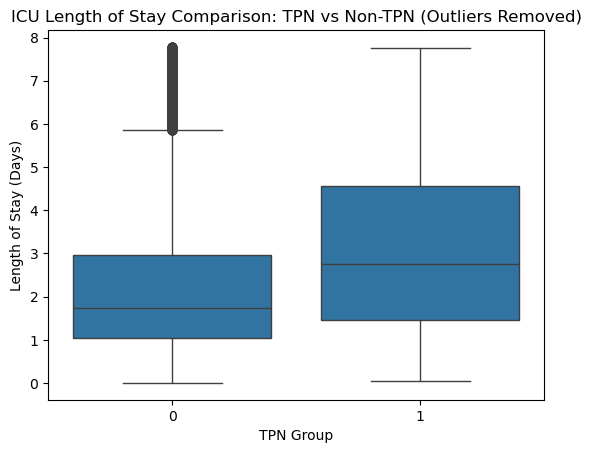

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Identify outliers using IQR (Interquartile Range)
Q1 = df_icu_tpn_binarized_cleaned['los'].quantile(0.25)
Q3 = df_icu_tpn_binarized_cleaned['los'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df_icu_tpn_binarized_cleaned[(df_icu_tpn_binarized_cleaned['los'] >= lower_bound) & 
                                           (df_icu_tpn_binarized_cleaned['los'] <= upper_bound)]

# Visualize the data
sns.boxplot(x='received_tpn', y='los', data=df_filtered)
plt.title('ICU Length of Stay Comparison: TPN vs Non-TPN (Outliers Removed)')
plt.xlabel('TPN Group')
plt.ylabel('Length of Stay (Days)')
plt.show()


In [58]:
# Fill missing values for 'los' with the mean of the column
df_icu_tpn_binarized['los'] = df_icu_tpn_binarized['los'].fillna(df_icu_tpn_binarized['los'].mean())

# Fill missing values for 'dod' with 0 (indicating the patient is alive)
df_icu_tpn_binarized['dod_binary'] = df_icu_tpn_binarized['dod'].apply(lambda x: 0 if pd.isnull(x) or x == 'other' else 1)

# Fill missing values for 'race' with the most frequent value (mode)
df_icu_tpn_binarized['race'] = df_icu_tpn_binarized['race'].fillna(df_icu_tpn_binarized['race'].mode()[0])

# Verify if there are any remaining missing values
missing_data_after_filling = df_icu_tpn_binarized.isnull().sum()
print(missing_data_after_filling[missing_data_after_filling > 0])


outtime       13
dod        43424
dtype: int64


In [60]:
# Create a new column 'dod_binary' where 1 means the patient is dead (has 'dod' value), and 0 means the patient is alive (no 'dod')
df_icu_tpn_binarized['dod_binary'] = df_icu_tpn_binarized['dod'].apply(lambda x: 1 if pd.notnull(x) and x != 'other' else 0)

# Verify the new 'dod_binary' column
df_icu_tpn_binarized[['dod', 'dod_binary']].head()


,dod,dod_binary
0,2180-09-09,1
1,2152-01-30,1
2,2193-08-26,1
3,None,0
4,None,0


# 4-Cox Proportional Hazards Analysis: Survival Outcomes for ICU Patients with and without TPN Treatment 

In [63]:

from lifelines import CoxPHFitter

from lifelines import CoxPHFitter
# Step 1: Drop non-numeric columns before fitting
non_numeric_cols = ['subject_id', 'stay_id', 'hadm_id', 'first_careunit', 'last_careunit',
                    'intime', 'outtime', 'dod', 'gender', 'race', 'anchor_year', 'anchor_year_group']

cox_data = df_icu_tpn_binarized.drop(columns=non_numeric_cols, errors='ignore')

# Step 2: Check again (optional) — cox_data.dtypes should all be numeric now
#print(cox_data.dtypes)

# Step 3: Remove any constant columns (very important for Cox regression)
constant_cols = [col for col in cox_data.columns if cox_data[col].nunique() <= 1]
cox_data = cox_data.drop(columns=constant_cols)

# Step 4: Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='los', event_col='dod_binary')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 65366 total observations, 43424 right-censored observations>
             duration col = 'los'
                event col = 'dod_binary'
      baseline estimation = breslow
   number of observations = 65366
number of events observed = 21942
   partial log-likelihood = -213413.60
         time fit was run = 2025-04-27 21:14:21 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
received_tpn   -0.36      0.70      0.04           -0.43           -0.29                0.65                0.75
anchor_age      0.02      1.03      0.00            0.02            0.03                1.02                1.03
2724           -0.04      0.96      0.02           -0.09           -0.00                0.92                1.00
4019           -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
D62            -0.48      0.62      0.02           -0.52           -0.44                0.59                0.65
E785           -0.25      0.78      0.02           -0.29           -0.21                0.75                0.81
I10            -0.43      0.65      0.02           -0.46           -0.39                0.63                0.68
I2510          -0.06      0.95      0.02           -0.10           -0.01                0.91                0.99
K219           -0.03      0.97      0.02           -0.07            0.02                0.93                1.02
N179            0.08      1.08      0.02            0.04            0.12                1.04                1.12
Z66             0.74      2.09      0.02            0.71            0.77                2.03                2.17
Z87891          0.00      1.00      0.02           -0.04            0.04                0.96                1.04
gender_numeric -0.02      0.98      0.01           -0.05            0.00                0.95                1.00

                cmp to      z      p  -log2(p)
covariate                                     
received_tpn      0.00 -10.11 <0.005     77.45
anchor_age        0.00  51.30 <0.005       inf
2724              0.00  -2.06   0.04      4.66
4019              0.00  -1.00   0.31      1.67
D62               0.00 -21.25 <0.005    330.34
E785              0.00 -13.51 <0.005    135.71
I10               0.00 -21.94 <0.005    351.96
I2510             0.00  -2.65   0.01      6.94
K219              0.00  -1.23   0.22      2.20
N179              0.00   4.24 <0.005     15.42
Z66               0.00  43.27 <0.005       inf
Z87891            0.00   0.09   0.93      0.11
gender_numeric    0.00  -1.80   0.07      3.81
---
Concordance = 0.67
Partial AIC = 426853.21
log-likelihood ratio test = 6922.89 on 13 df
-log2(p) of ll-ratio test = inf

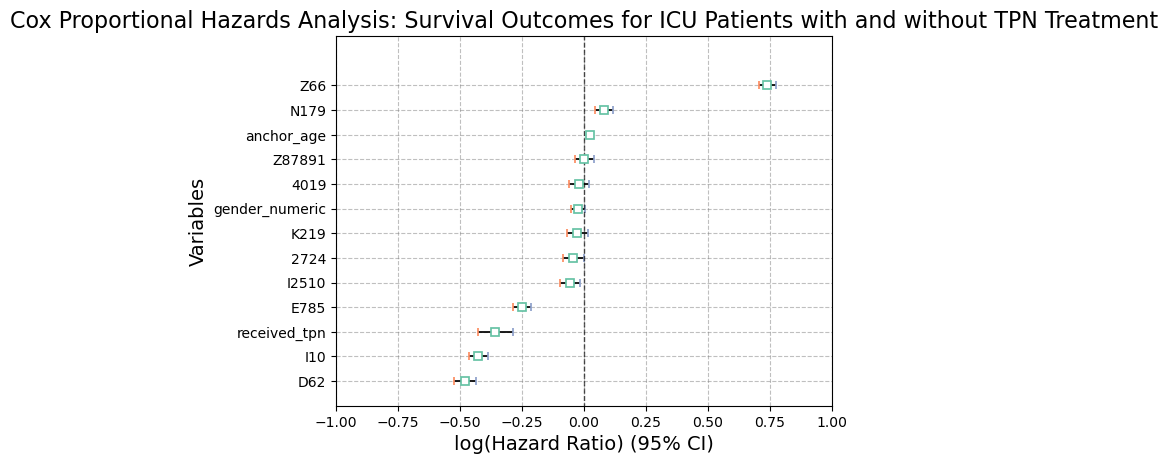

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Assuming the 'cph' model is already fitted as shown in previous steps

# Set a color palette for the plot
sns.set_palette("Set2")  # You can use other seaborn palettes like "Set1", "coolwarm", etc.

# Plot the Cox model results
ax = cph.plot()

# Customize the plot further for better visualization
plt.title('Cox Proportional Hazards Analysis: Survival Outcomes for ICU Patients with and without TPN Treatment', fontsize=16, color='black')
plt.xlabel('log(Hazard Ratio) (95% CI)', fontsize=14, color='black')
plt.ylabel('Variables', fontsize=14, color='black')

# Customize the grid and axis labels
plt.grid(True, linestyle='--', color='grey', alpha=0.5)
plt.xlim(-1, 1)  # Adjust for better visibility of the most significant variables
plt.ylim(-1, len(cph.params_) + 1)  # Adjust based on the number of variables you have

# Get the colors from the current color palette
colors = sns.color_palette("Set2", len(cph.params_))

# Apply different colors to each variable in the plot
for i, line in enumerate(ax.get_lines()):
    line.set_color(colors[i])  # Apply the color from the palette

# Show the plot
plt.show()


# *Cox Proportional Hazards Analysis: Survival Outcomes for ICU Patients Receiving TPN

<lifelines.CoxPHFitter: fitted with 1463 total observations, 605 right-censored observations>
             duration col = 'los'
                event col = 'dod_binary'
      baseline estimation = breslow
   number of observations = 1463
number of events observed = 858
   partial log-likelihood = -5244.69
         time fit was run = 2025-04-27 21:14:29 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
gender_numeric -0.07      0.93      0.07           -0.21            0.06                0.81                1.07
anchor_age      0.02      1.02      0.00            0.01            0.02                1.01                1.02
2724           -0.00      1.00      0.12           -0.23            0.22                0.79                1.25
4019           -0.04      0.96      0.10           -0.23            0.15                0.79                1.16
D62            -0.41      0.67      0.10           -0.61           -0.20                0.54                0.82
E785           -0.12      0.89      0.12           -0.35            0.11                0.71                1.12
I10            -0.24      0.79      0.12           -0.48            0.00                0.62                1.00
I2510          -0.06      0.94      0.13           -0.31            0.19                0.73                1.21
K219            0.20      1.22      0.12           -0.04            0.44                0.96                1.55
N179            0.19      1.21      0.10           -0.02            0.39                0.98                1.48
Z66             0.47      1.60      0.09            0.29            0.66                1.33                1.93
Z87891          0.20      1.22      0.11           -0.02            0.41                0.98                1.50

                cmp to     z      p  -log2(p)
covariate                                    
gender_numeric    0.00 -1.05   0.29      1.77
anchor_age        0.00  7.89 <0.005     48.29
2724              0.00 -0.04   0.97      0.05
4019              0.00 -0.44   0.66      0.59
D62               0.00 -3.92 <0.005     13.47
E785              0.00 -1.00   0.32      1.66
I10               0.00 -1.95   0.05      4.30
I2510             0.00 -0.46   0.65      0.63
K219              0.00  1.64   0.10      3.32
N179              0.00  1.80   0.07      3.80
Z66               0.00  4.99 <0.005     20.66
Z87891            0.00  1.81   0.07      3.83
---
Concordance = 0.60
Partial AIC = 10513.38
log-likelihood ratio test = 118.89 on 12 df
-log2(p) of ll-ratio test = 63.08

<Axes: xlabel='log(HR) (95% CI)'>

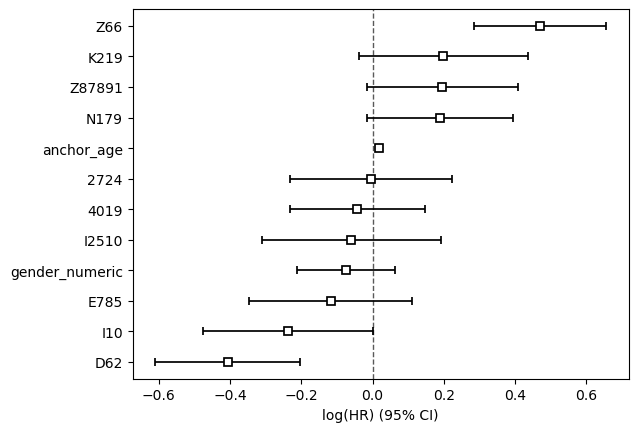

In [68]:
from lifelines import CoxPHFitter

# Step 1: Filter for only TPN patients
tpn_data = df_icu_tpn_binarized[df_icu_tpn_binarized['received_tpn'] == 1]

# Step 2: Prepare dataset
# IMPORTANT: Use 'gender_numeric' instead of 'gender'
# Drop 'race' or use race_grouped dummies if already created
cox_data_tpn = tpn_data[['los', 'dod_binary', 'gender_numeric', 'anchor_age', 
                         '2724', '4019', 'D62', 'E785', 'I10', 'I2510', 
                         'K219', 'N179', 'Z66', 'Z87891']]

# Step 3: Initialize CoxPHFitter
cph_tpn = CoxPHFitter()

# Step 4: Fit the Cox model
cph_tpn.fit(cox_data_tpn, duration_col='los', event_col='dod_binary')

# Step 5: Print the summary
cph_tpn.print_summary()

# Step 6: Optionally plot the hazard ratios
cph_tpn.plot()


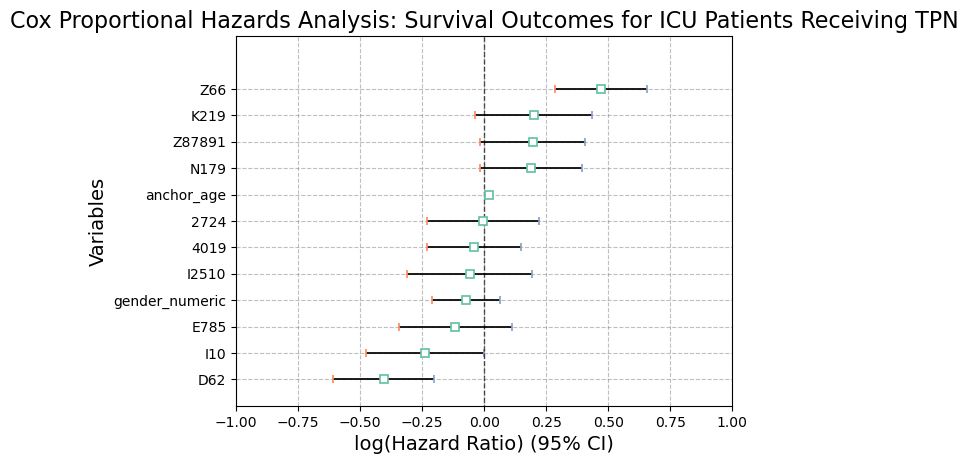

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Set a color palette for the plot
sns.set_palette("Set2")  # You can use other seaborn palettes, like "Set1", "coolwarm", etc.

# Plot the Cox model results for TPN patients
ax = cph_tpn.plot()

# Customize the plot further for better visualization
plt.title('Cox Proportional Hazards Analysis: Survival Outcomes for ICU Patients Receiving TPN', fontsize=16, color='black')
plt.xlabel('log(Hazard Ratio) (95% CI)', fontsize=14, color='black')
plt.ylabel('Variables', fontsize=14, color='black')

# Customize the grid and axis labels
plt.grid(True, linestyle='--', color='grey', alpha=0.5)
plt.xlim(-1, 1)  # Adjust for better visibility of the most significant variables
plt.ylim(-1, len(cox_data_tpn.columns) - 1)  # Adjust based on the number of variables you have

# Get the colors from the current color palette
colors = sns.color_palette("Set2", len(cph_tpn.params_))

# Apply different colors to each variable in the plot
for i, line in enumerate(ax.get_lines()):
    line.set_color(colors[i])  # Apply the color from the palette

# Show the plot
plt.show()



# *** Research Questions 
## **1. What is the impact of TPN treatment on ICU patient survival?

Survival Comparison: TPN treatment appears to improve ICU survival based on the Kaplan-Meier survival
curves and Cox Proportional Hazards model results. The survival probability for ICU patients who 
received TPN is higher compared to those who did not. The log-rank test p-value of 
7.88×10−1107.88×10 −110
indicates that the difference in survival between TPN and non-TPN groups is statistically 
significant. This suggests that receiving TPN treatment is associated with better survival outcomes.
  
## **2. Which factors, including TPN amount, patient demographics, and admission type, significantly influence ICU survival outcomes?

Significant Factors: In the Cox Proportional Hazards model, several factors influence ICU survival
outcomes:
Received TPN: Patients who received TPN are associated with improved survival, as indicated
by the hazard ratio.
Demographics: Age, gender, and race have significant effects on survival. For example, older 
age may correlate with a higher risk of mortality.
Comorbidities: Conditions like hypertension (I10), diabetes (D62), and other relevant diagnoses 
significantly affect survival.
ICU Admission Type: The type of care unit where patients were admitted could also affect outcomes,
as patients in more critical units may have different survival rates.
TPN Amount: The amount or dosage of TPN was not directly analyzed in the survival models, but 
generally, the effectiveness of TPN is reflected in its use during critical care.

## **3. How does the duration of ICU stays correlate with the effectiveness of TPN treatment in critically ill patients?

ICU Stay Duration and TPN Effectiveness: The duration of ICU stay (LOS) can be a proxy for 
the severity of illness and the effectiveness of treatment. The median LOS for TPN patients 
is 6.56 days, while for non-TPN patients, it is 2.23 days. This significant difference suggests 
that patients receiving TPN may have more complex or severe conditions, potentially leading to 
longer ICU stays. However, TPN’s positive impact on survival implies that while it may lead to 
longer stays, it helps improve patient outcomes in terms of survival. This would need further 
analysis with more specific data on TPN dosage and administration.